

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a time series data to be modeled and predicted using RNNs. 

In [2]:
#
# Import Libraries
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

## Data

We will use retail data for time-series modeling. 

Link to the dataset:
 https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at:
https://www.census.gov/retail/marts/about_the_surveys.html

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted
Frequency:  Monthly

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

### Read data first -  Use index_col = 'DATE' and 'parse_dates = True' as a parameter.

In [3]:
# Your code to read data
df = pd.read_csv('MRTSSM448USN.csv', index_col='DATE', parse_dates=True)
# Print first few rows of data

df.head(5)

,MRTSSM448USN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Does the sales column has any name?

If no, set the name of the colum as 'Sales'.

In [4]:
# Set name of column as 'Sales'. Use - df.columns 
df.columns = ['Sales']

df.head()



,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


Plot your data - Year vs Sales

<Axes: xlabel='DATE'>

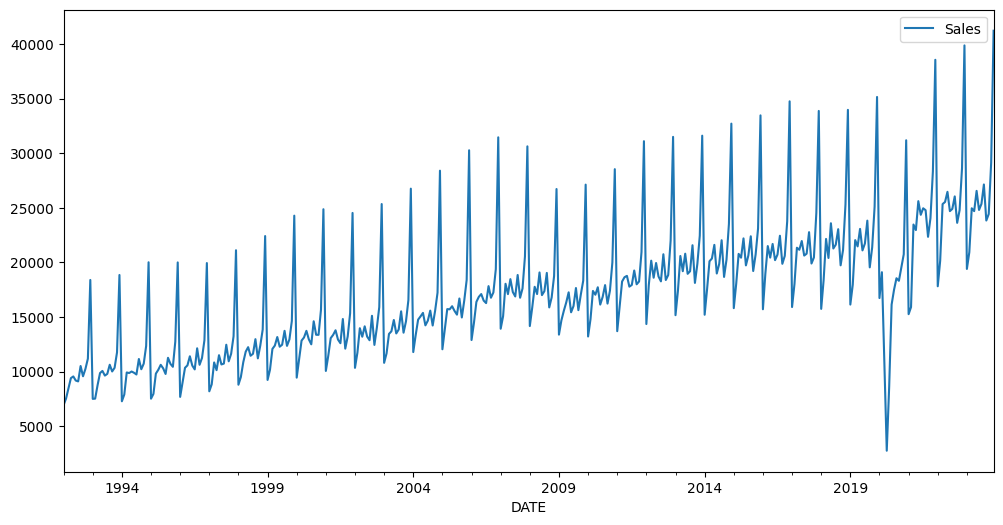

In [6]:
df.plot(figsize=(12, 6))

### Next we will do Train Test Split. 

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [13]:
# Assign variable test size = 18
# Store length of data in variable length.
# store training size in varialable train_size (Remember training size = total size - test_size)
test_size = 18
data_length = len(df)
print(data_length)
train_size = data_length - test_size
train_size


test_index = train_size

train = df.iloc[:test_index]

384


Now, we will find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

In [6]:
#Assign the start of test index in data frame to variable test_index.  Remember, it is equal to the length of dataframe - test size

Next, we will separate train and test datasets.

In [10]:
# Store all data from 0 to test_index in variable train. Hint - Use df.iloc.
# Store everthing from test_index to the last sample in test variable. Hint - Use df.iloc.

test = df.iloc[test_index:]
test

,Sales
DATE,
2022-07-01,24904.0
2022-08-01,26049.0
2022-09-01,23629.0
2022-10-01,24787.0
2022-11-01,28645.0
2022-12-01,39883.0
2023-01-01,19405.0
2023-02-01,20937.0
2023-03-01,24963.0


In [9]:
# Print the size of the train data
train.shape, test.shape
# Print the size of the test data
# Print the train data
# Print the test data
print(test)


              Sales
DATE               
2022-07-01  24904.0
2022-08-01  26049.0
2022-09-01  23629.0
2022-10-01  24787.0
2022-11-01  28645.0
2022-12-01  39883.0
2023-01-01  19405.0
2023-02-01  20937.0
2023-03-01  24963.0
2023-04-01  24700.0
2023-05-01  26557.0
2023-06-01  24809.0
2023-07-01  25364.0
2023-08-01  27143.0
2023-09-01  23840.0
2023-10-01  24438.0
2023-11-01  29150.0
2023-12-01  41228.0


In [12]:
print(train.size)
print(test.size)

366
18


In [14]:
print(train.dtypes)

Sales    float64
dtype: object


### In Neural Networks, we need to Scale Data between 0-1

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
#
# Check if the data has been scaled properly
#

print(scaled_train.max())
print(scaled_train.min())

1.0
0.0


# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

# We will use 12 months as input and then predict the next month out


In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.11688819 0.13325142 0.15980677 0.18566402 0.19004803 0.17954875
 0.17734279 0.21671507 0.19046688 0.20948285 0.23553557 0.43680889]
Predict this y: 
 [[0.1326371]]


### Create the Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU

import tensorflow as tf

In [21]:
# We're only using one feature in our time series
n_features = 1

# Define your own models. 

Use 1. SimpleRNN, LSTM, or GRU neural network.

APIs:
https://keras.io/api/layers/recurrent_layers/

In [37]:
# 
# Your code to create your own model
#

model = Sequential()
model.add(tf.keras.Input(shape=(length,n_features)))

model.add(LSTM(100, activation='relu'))
model.add(Dense(1))






In [38]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer='adam', loss='mse')

### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [40]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

# Your code to create an object early-stop.
early_stop = EarlyStopping(monitor='val_loss', patience=4)

Now, fit your model.

In [42]:
# Your code to fit your model.
model.fit(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop],)

Epoch 1/20


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0379 - val_loss: 0.0596
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0287
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0114 - val_loss: 0.0031
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0096
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057 - val_loss: 5.6729e-04
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072 - val_loss: 3.3311e-04
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - val_loss: 0.0132
Epoch 9/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 7.9661e-04
Epoch 10/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 11/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 5.8923e-04


<Axes: >

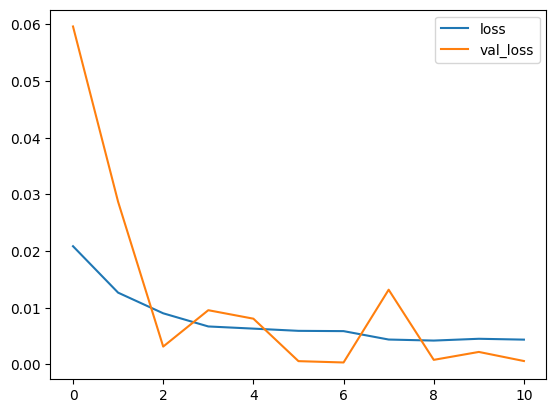

In [43]:
# Get Losses from dataframe (hint - model.history.history)- See previous week tutorial.
# Plot losses in the dataframe.

losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [44]:
first_eval_batch = scaled_train[-length:]

In [45]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


array([[0.6313943]], dtype=float32)

In [46]:
# compare with the true result:
scaled_test[0]

array([0.61856361])

#### Try predicting the series!

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


## Inverse Transformations and Compare

In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

In [49]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/var/folders/z2/r31j11rx681gjcqg67f9y2km0000gn/T/ipykernel_42495/1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


# Check and plot predictions

In [50]:
# Print the test variable.
test


,Sales,Predictions
DATE,,
2022-07-01,24904.0,25363.493627
2022-08-01,26049.0,25333.650322
2022-09-01,23629.0,24085.328851
2022-10-01,24787.0,25062.020963
2022-11-01,28645.0,28059.984895
2022-12-01,39883.0,39181.221276
2023-01-01,19405.0,22235.398286
2023-02-01,20937.0,23238.460771
2023-03-01,24963.0,26105.095804


<Axes: xlabel='DATE'>

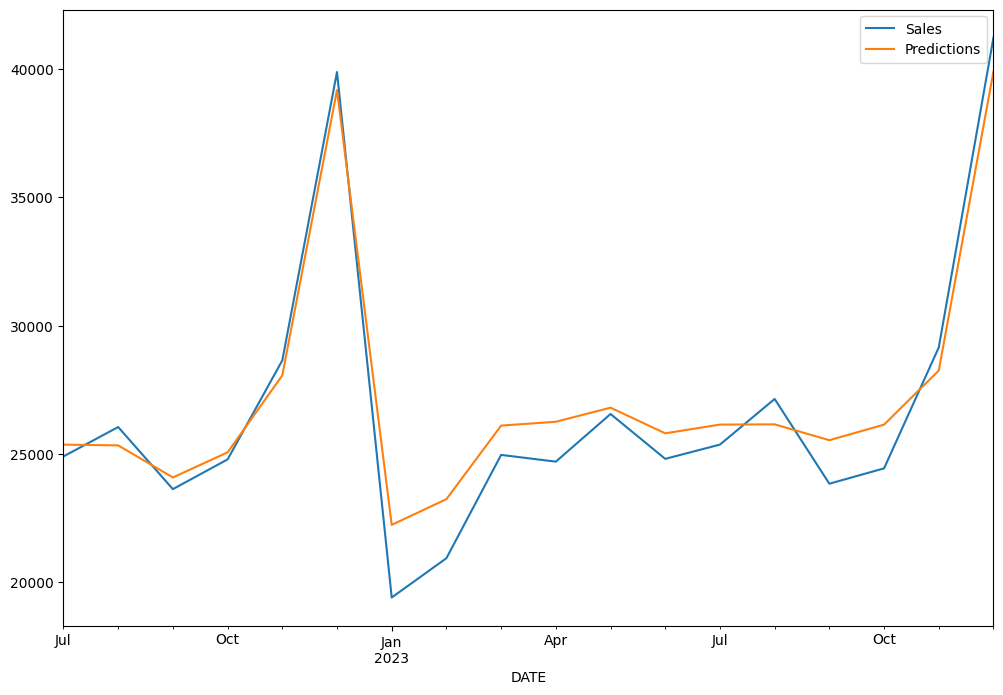

In [51]:
# Your code to plot actual sales and predictions.
test.plot(figsize=(12, 8))


# Retrain and Forecasting

In [52]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [53]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, length=length, batch_size=1)

In [54]:
#
# Use any neural network model based on RNN
#
# Create the model

model = Sequential()
model.add(tf.keras.Input(shape=(length,n_features)))

model.add(LSTM(100, activation='relu'))
model.add(Dense(1))



In [55]:

model.compile(optimizer='adam', loss='mse')


In [58]:
# use early_stop

early_stop = EarlyStopping(monitor='loss', patience=4)



In [59]:
# fit the model
model.fit(generator,epochs=20, callbacks=[early_stop])

Epoch 1/20


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025
Epoch 5/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039
Epoch 6/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011  
Epoch 7/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013
Epoch 8/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021
Epoch 9/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023
Epoch 10/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010   
Epoch 11/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019
Epoch 12/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 13/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017


In [60]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for  grabbing just the number instead of [array])
    
    
    # store prediction forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value

    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [61]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [62]:
df

,Sales
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0
...,...
2023-08-01,27143.0
2023-09-01,23840.0
2023-10-01,24438.0


In [63]:
forecast_index = pd.date_range(start='2024-01-01',periods=periods,freq='MS')

In [64]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [65]:
forecast_df

,Forecast
2024-01-01,18259.312086
2024-02-01,19349.511642
2024-03-01,21569.026596
2024-04-01,21789.838449
2024-05-01,22975.704784
2024-06-01,22675.186269
2024-07-01,23176.069672
2024-08-01,24976.230800
2024-09-01,23299.712015
2024-10-01,23638.582197


<Axes: xlabel='DATE'>

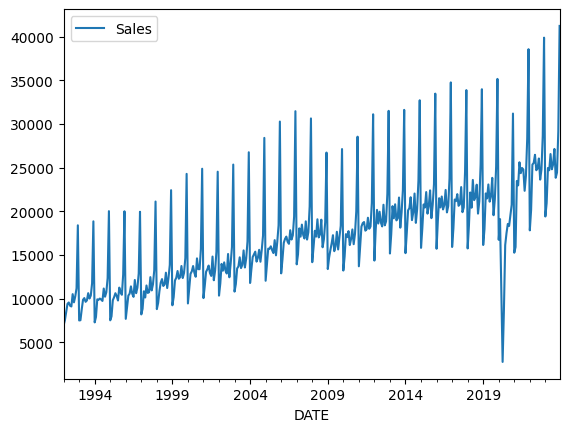

In [66]:
# Plot sales - Values in dataframe
df.plot()


<Axes: >

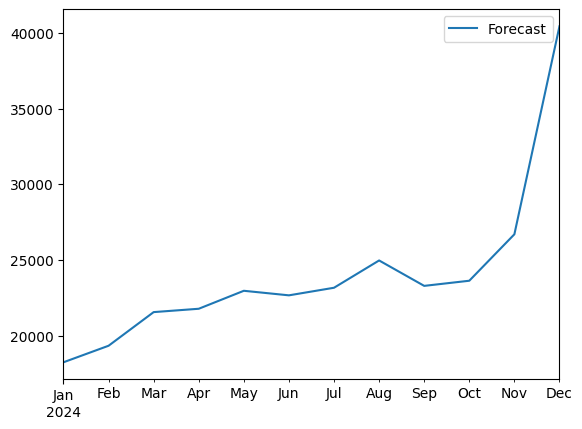

In [67]:
# Plot forecast - Values in forecast_df
forecast_df.plot()


### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<Axes: xlabel='DATE'>

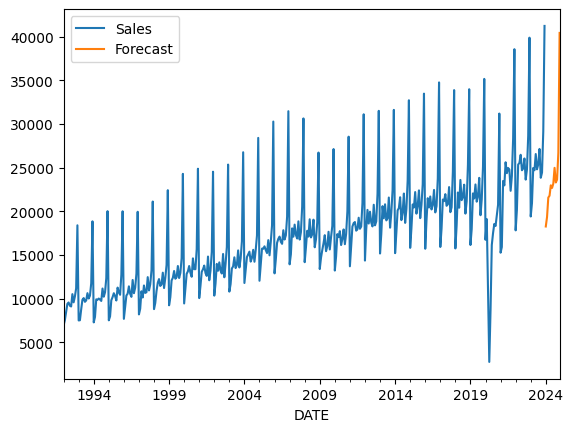

In [68]:
ax = df.plot()
forecast_df.plot(ax=ax)

(624.0, 660.0)

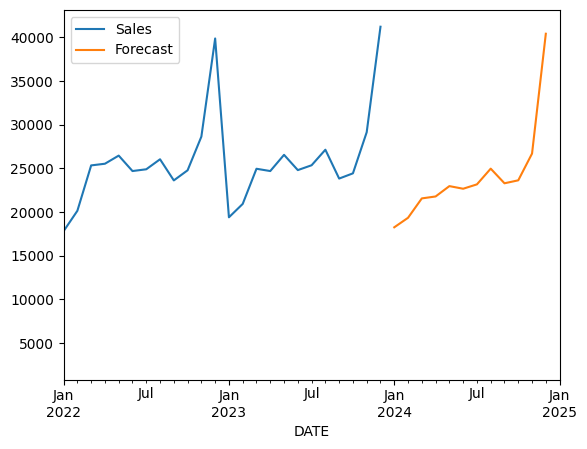

In [69]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2022-01-01','2025-01-01')

# Try the same example with a LSTM and GRU! 
Hint: Use LSTM instead of SimpleRNN!